Notebook to test kernel herding with a GAN generator.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#%config InlineBackend.figure_format = 'svg'
#%config InlineBackend.figure_format = 'pdf'

In [2]:
import kbrgan
import kbrgan.kernel as kernel
import kbrgan.glo as glo
import kbrgan.main as main
import kbrgan.plot as plot
import kbrgan.embed as embed
import kbrgan.util as util

import matplotlib
import matplotlib.pyplot as plt
import os
import numpy as np
import scipy.stats as stats
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

/home/wgondal/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
# font options
font = {
    #'family' : 'normal',
    #'weight' : 'bold',
    'size'   : 18
}

plt.rc('font', **font)
plt.rc('lines', linewidth=2)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [4]:
use_cuda = True and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

torch.set_default_tensor_type(torch.cuda.FloatTensor if use_cuda else torch.FloatTensor)


In [5]:
model_path = glo.prob_model_folder('fashion_dcgan/fashion_mnist_cnn_ep11_s1.pt')
print (model_path)

/home/wgondal/kbrgan/prob_models/fashion_dcgan/fashion_mnist_cnn_ep11_s1.pt


## Feature extractor for Fashion MNIST

In [48]:
model_path = glo.prob_model_folder('fashion_dcgan/fashion_mnist_cnn_ep11_s1.pt')

# load the model
#import kbrgan.fashion_mnist.classify as mnist_classify
from kbrgan.fashion_mnist.classify import MnistClassifier_GAP

# load option depends on whether GPU is used
load_options = {} if use_cuda else {'map_location': lambda storage, loc: storage} 

classifier = MnistClassifier_GAP.load(model_path, **load_options)
classifier = classifier.eval()
classifier = classifier.to(device)
# classifier = classifier.cuda()

def extractor(imgs):
    """
    Feature extractor
    """
#     return classifier.features(imgs)
    self = classifier
    x = imgs
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2(x), 2))

#     x = x.view(-1, 10*12*12)
    x = x.view(-1, 320)
#     x = x.view(-1)
#     x = F.relu(self.fc1(x))
    return x

def extractor_cam(imgs):
    """
    Feature extractor
    """
#     return classifier.features(imgs)
    self = classifier
    x = imgs
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2(x), 2))
    x = F.adaptive_avg_pool2d(x, (1, 1)).squeeze()
    x = classifier.fc1(x).unsqueeze(0)
    return x


In [30]:
uu = F.relu(F.max_pool2d(classifier.conv1(X), 2))
uu = F.relu(F.max_pool2d(classifier.conv2(uu), 2))
print (uu.size()) # Either you can do dot prodcut here or let it go with FC1
uu = F.adaptive_avg_pool2d(uu, (1, 1)).squeeze()
print (uu.size())
h = classifier.fc1(uu)
print (h.size())

torch.Size([1, 20, 4, 4])
torch.Size([20])
torch.Size([10])


In [10]:
# load MNIST data
mnist_folder = glo.data_file('/home/wgondal/kbrgan/data/fashion')
mnist_dataset = torchvision.datasets.MNIST(mnist_folder, train=False, 
                        transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]))
torchvision.datasets.MNIST(mnist_folder, train=False, )

Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: /home/wgondal/kbrgan/data/fashion
    Transforms (if any): None
    Target Transforms (if any): None

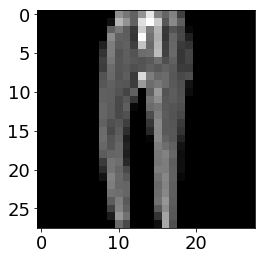

In [12]:
xy = mnist_dataset[80]
x = xy[0]
x = x.unsqueeze(0)
x = x.to(device)

# plot
xnp = np.transpose(xy[0].numpy(), (1, 2, 0))
xnp = xnp.squeeze()
plt.imshow(xnp, cmap = 'gray')
#print('features: ', classifier(x))

## A generator for MNIST

In [13]:
import kbrgan.fashion_mnist.dcgan as mnist_dcgan

gan_fname = 'fashion_dcgan_ep_{}_bs{}.pt'.format(35, 64)
gan_fpath = glo.prob_model_folder('fashion_dcgan', gan_fname)
# load a model
g = mnist_dcgan.Generator.load(gan_fpath, **load_options)
g = g.to(device)

latent_dim = 100
f_noise = lambda n: torch.randn(n, latent_dim).float()

## Optimize points jointly to minimize the moment matching loss

With a GAN generator. Optimize in the latent space.

In [ ]:
# def resize_gen_img(y):
#     # original Mnist images are 28x28 pixels
#     # The generator generates 32x32 images.
#     # Apply the following rescaling filter: 32x32 -> 28x28.
    
# #     y = y.clone() # need this clone because Normalize modifies in-place.
#     downscale_op = transforms.Compose([
#         # undo the range normalization
#         # When training the GAN, the following was used: transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#         transforms.Normalize((0,), (1.0/0.5,)),
#         transforms.Normalize((-0.5,), (1,)),
#         transforms.ToPILImage(),
#         transforms.Resize((28, 28)),
#         transforms.ToTensor(),
#         # renormalize
#         transforms.Normalize((0.1307,), (0.3081,)),
#     ])
#     return downscale_op(y)

# def scale_up_real_img(x):
#     """
#     original Mnist images are 28x28 pixels
#     The generator generates 32x32 images.
#     Apply the following rescaling filter on real Mnist iamges: 28x28 -> 32x32
#     """
#     downscale_op = transforms.Compose([
#         # undo the range normalization
#         # When training the GAN, the following was used: transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#         transforms.Normalize((0,), (1.0/0.3081,)),
#         transforms.Normalize((-0.1307,), (1,)),
#         transforms.ToPILImage(),
#         transforms.Resize((32, 32)),
#         transforms.ToTensor(),
#         # renormalize
#         transforms.Normalize((0.1307,), (0.3081,)),
#     ])
#     return downscale_op(y)

In [ ]:
# x = resize_gen_img(Y0[0].clone())
# plot.show_torch_imgs(x)

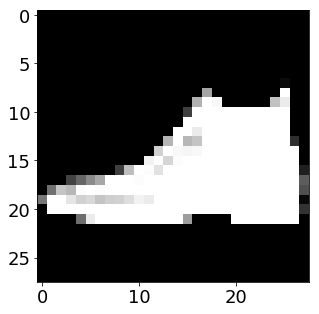

In [14]:
def sample_by_labels(data, label_counts):
    """
    data: a dataset such that data[i][0] is a point, and data[i][1] is an integer label.
    label_counts: a list of tuples of two values (A, B), where A is a label, and B is the count.
    """
    list_selected = []
    labels = np.array([data[i][1] for i in range(len(data))])
    for label, count in label_counts:
        inds = np.where(labels==label)[0]
        homo_data = [data[i][0] for i in inds[:count]]
        list_selected.extend(homo_data)
    # stack all
    selected = torch.stack(list_selected)
    return selected

# The set of points representing the mean embedding that we want to sample from.
# As an example, we will construct this manually.
# img_indices = [2, 5, 9, 12, 14, 16, 17, 20, 26, 29, 31, 34, 36, 37]
# img_indices = [2, 5, 14, 29, 31, 37, 39, 40, 46, 57]
# img_indices = [3, 5]
# X = torch.stack([mnist_dataset[i][0] for i in img_indices], dim=0)

# label_counts = [(1, 5), (9, 5)]
#label_counts = [(1, 6), (7, 2)]
label_counts = [(9, 1)]
#label_counts = [(1, 7)]
#label_counts = [(6, 2), (8, 2)]
# label_counts = [(1,1), (2,1), (3,1), (4,1)]
# label_counts = [(i, 5) for i in range(10)]
# label_counts = [(0, 6), (5, 3)]
X = sample_by_labels(mnist_dataset, label_counts)
X = X.to(device)
n = X.shape[0]

# A vector of weights for all the points in X
weights = torch.ones(n)/float(n)
weights = weights.to(device)
plot.show_torch_imgs(X.clamp(0,1))

/home/wgondal/miniconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


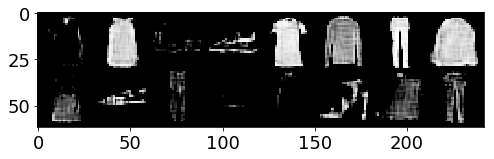

In [15]:
# initial points in the latent space
# n_sample = 2*2**3
# n_sample = 2*8
n_sample = 8*2
# noise vectors
Z = f_noise(n_sample)
Z = Z.to(device)

Z.requires_grad = True
Y0 = g(Z)

# plot the initial points in the image space
plot.show_torch_imgs(Y0.clamp(0,1).detach(), nrow=8)

In [16]:
# avgpool = torch.nn.AvgPool2d(5, stride=1, padding=0)
# avgpool = avgpool.to(device)
# scaled = avgpool(Y0).detach()
# plot.show_torch_imgs(scaled)
# scaled.shape

In [49]:
# optimizer = torch.optim.SGD([Y], lr=5e-3)
# optimizer = torch.optim.RMSprop([Z], lr=1e-2)
optimizer = torch.optim.Adam([Z], lr=5e-2)
# kernel on the extracted features
# k = kernel.PTKGauss(sigma2=50.0)
k = kernel.PTKPoly(c=1e-1, d=2)
# k = kernel.PTKIMQ()
# k = kernel.PTKLinear()

# kernel on the latent noise vectors
# k = kernel.PTKFuncCompose(kgauss, classifier)

# pre-extract the features of X. Fixed throughout the optimization

with torch.no_grad():
    FX = extractor_cam(X)

In [50]:
print (F_gz.size(), FX.size())

torch.Size([16, 10]) torch.Size([1, 10])


/home/wgondal/miniconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


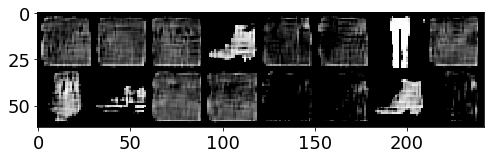

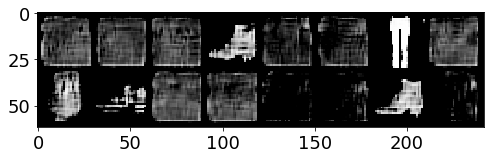

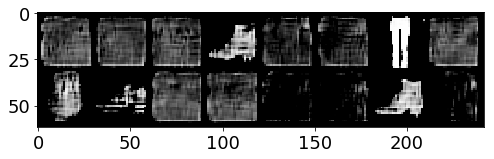

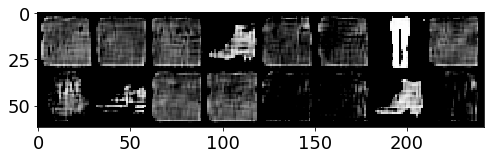

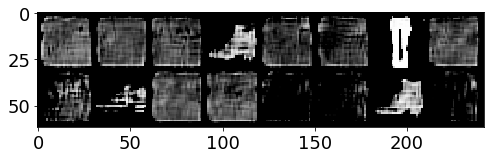

In [54]:
# optimization
n_iter = 1000
losses = []
sample_interval = 200
# avgpool = torch.nn.AvgPool2d(5, stride=1, padding=0)

mean_KFX = torch.mean(k.eval(FX, FX))
for t in range(n_iter):
    # need to resize since Mnist uses 28x28. The generator generates 32x32
    gens = g(Z)
#     resized = torch.stack([resize_gen_img(I) for I in gens], 0)
#     resized = avgpool(gens)
#     plot.show_torch_imgs(resized)
    F_gz = extractor_cam(gens)
    F_gz = F_gz.squeeze()
    KF_gz = k.eval(F_gz, F_gz)
#     print(KF_gz)
    
    # encourage the latent noise vectors to concentrate around 0
#     Z_reg = 1e+2*torch.mean(torch.sum(Z**2, 1))
#     Z_reg = -torch.mean(torch.log(4.0**2-Z**2))
    #Z_reg = 0
    Z_reg = 1e-2*torch.mean(torch.mean(Z**2, 1))
    #print (weights.size())
    t1 = k.eval(F_gz, FX).mv(weights)
    #print (t1.size())
    
    
    
    loss = torch.mean(KF_gz)  - 2.0*torch.mean(k.eval(F_gz, FX).mv(weights)) + mean_KFX  + Z_reg
    losses.append(loss.item())
    
    optimizer.zero_grad()
    
    # compute the gradients
    loss.backward(retain_graph=True)
    # updates
    optimizer.step()
    
    #--------- plots the generated images ----
    if t%sample_interval==0:
        with torch.no_grad():
            gen = g(Z.detach().clone())
#             gen = Z.detach().clone()
#             gen = Z.grad.detach().clone()
            plot.show_torch_imgs(gen.clamp(0,1))
            plt.show()
    

Text(0.5,1,'Output')

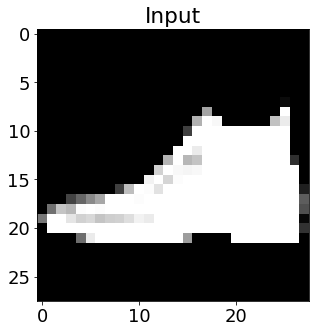

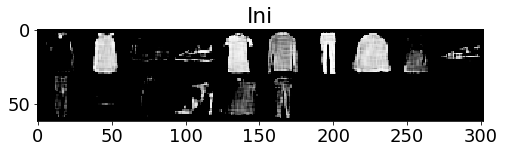

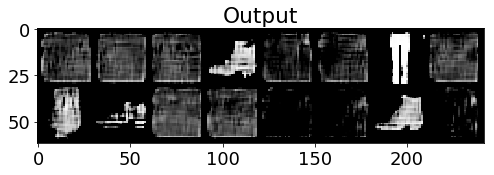

In [53]:
# input points
plot.show_torch_imgs(X.clamp(0,1))
plt.title('Input')
plot.show_torch_imgs(Y0.detach().clamp(0,1), nrow=10)
plt.title('Ini')
plot.show_torch_imgs(gen.clamp(0,1))
plt.title('Output')

Text(0,0.5,'Herding loss')

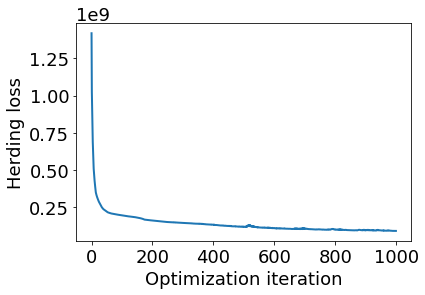

In [20]:
plt.plot(losses)
plt.xlabel('Optimization iteration')
plt.ylabel('Herding loss')

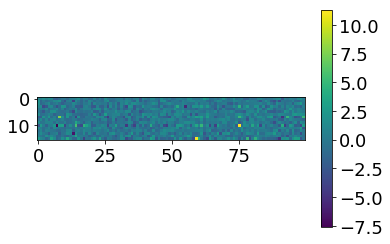

In [22]:
plt.imshow(Z.cpu().detach().numpy())
plt.colorbar()